In [1]:
import os
HOME = os.getcwd()
print(HOME)
#HOME dir variable

/content


In [2]:
%cd {HOME}


/content


In [3]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"
#source of video
#installing OpenVino
!pip install -q 'openvino-dev>=2023.0.0' 'nncf>=2.5.0'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.4/706.4 kB 58.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 24.5 MB/s eta 0:00:00


In [4]:
#install ultralytics  YOLOv8
#!pip install ultralytics
!pip install -q 'ultralytics==8.0.43' onnx

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()


import collections
import os
import sys
import time
from typing import Tuple, List

import cv2
import numpy as np
from IPython import display
from openvino.runtime import Core
from openvino.runtime.ie_api import CompiledModel



Ultralytics YOLOv8.0.43 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.5/78.2 GB disk)


In [5]:
#install bytetrack for tracking objects (in this case cars, trucks or motorbykes)
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [6]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [7]:
# Install Roboflow Supervision
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__) #check installed version

supervision.__version__: 0.1.0


In [8]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [9]:
## Tracking utils
# Matching the boxes from model with the one from tracker
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
#Yolo

**Loading Yolo V8 model**

In [37]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")
model.fuse()

# object detection model
det_model_path = f"/content/ByteTrack/yolov8x_openvino_model/yolov8x.xml" #openvino model
model.export(format="openvino", dynamic=True, half=False)  #Convert to OpenVino IR format

from openvino.runtime import Core, Model

core = Core()
ov_model = core.read_model(det_model_path)
device = "CPU"  # "GPU"

compiled_model = core.compile_model(ov_model, device)


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs
Ultralytics YOLOv8.0.43 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU

PyTorch: starting from yolov8x.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (130.5 MB)

ONNX: starting export with onnx 1.14.0...


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 31.7s, saved as yolov8x.onnx (260.3 MB)
requirements: YOLOv8 requirement "openvino-dev>=2022.3" not found, attempting AutoUpdate...

requirements: 1 package updated per ['openvino-dev>=2022.3']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


OpenVINO: starting export with openvino 2023.0.1-11005-fa1c41994f3-releases/2023/0...
OpenVINO: export success ✅ 15.2s, saved as yolov8x_openvino_model/ (260.6 MB)

Export complete (54.8s)
Results saved to /content/ByteTrack
Predict:         yolo predict task=detect model=yolov8x_openvino_model imgsz=640 
Validate:        yolo val task=detect model=yolov8x_openvino_model imgsz=640 data=coco.yaml 
Visualize:       https://netron.app


In [28]:
CLASS_NAMES_DICT = model.model.names
# class_ids we only are interested in car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]

**Time to test model**


0: 384x640 1 person, 9 cars, 1 truck, 64.4ms
Speed: 0.8ms preprocess, 64.4ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


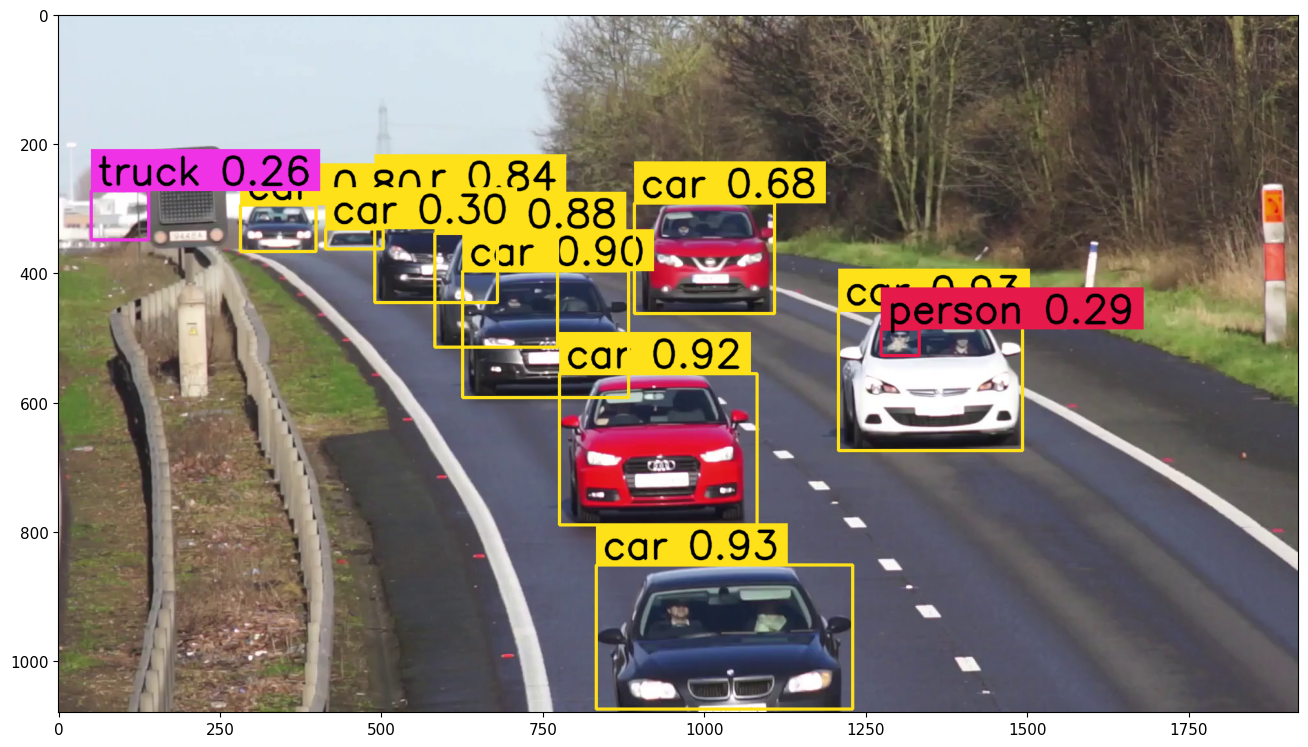

In [29]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [30]:
# predicting the whole video
# and adding line: start & end point
# when object crosses the line, the counter adds  one
LINE_START = Point(500, 800)
LINE_END = Point(1850, 800)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [17]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH) #informations of video

VideoInfo(width=1920, height=1080, fps=50, total_frames=3000)

In [15]:
#Start of tracker and OpenVino optimization
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/3000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
0: 384x640 2 persons, 6 cars, 30.6ms
Speed: 0.5ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 6 cars, 1 truck, 29.8ms
Speed: 0.7ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 7 cars, 1 truck, 30.8ms
Speed: 0.6ms preprocess, 30.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 6 cars, 1 truck, 34.1ms
Speed: 0.5ms preprocess, 34.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 6 cars, 1 truck, 32.3ms
Speed: 0.6ms preprocess, 32.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 6 cars, 1 truck, 31.2ms
Speed: 0.6ms preprocess, 31.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 7 cars, 31.6ms
Speed: 0.6ms preprocess, 31.6ms inference, 2.1ms postproce

In [16]:
#upload video to cloud
!curl --upload-file "/content/vehicle-counting-result.mp4" https://transfer.sh/vehicle-counting-result.mp4

https://transfer.sh/aPGe92nOEr/vehicle-counting-result.mp4